In [159]:
import numpy as np
import matplotlib.pyplot as plt
from  scipy.stats import multivariate_normal

In [197]:
#Generate Synthetic Dataset
np.random.seed(0)

def generate_synthetic_data(sigma):
    cov_matrix_a = sigma * np.array([[2, 0.5], [0.5, 1]])
    cov_matrix_b = sigma * np.array([[1, -0.5], [-0.5, 2]])
    cov_matrix_c = sigma * np.array([[1, 0], [0, 2]])
    
    points_a = np.random.multivariate_normal([-1, -1], cov_matrix_a, 100)
    points_b = np.random.multivariate_normal([1, -1], cov_matrix_b, 100)
    points_c = np.random.multivariate_normal([0, 1], cov_matrix_c, 100)
    
    return np.concatenate([points_a, points_b, points_c]), ['a'] * 100 + ['b'] * 100 + ['c'] * 100

def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))

def map_cluster_ids(labels):
    mapping = {'a': 0, 'b': 1, 'c': 2}
    mapped_labels = [mapping[label] for label in labels]
    return mapped_labels

In [196]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    def fit(self, X_train):
        # Randomly select centroid start points, uniformly distributed across the domain of the dataset
        min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        self.centroids = [np.random.uniform(min_, max_) for _ in range(self.n_clusters)]
        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        # J objective
        self._objective = np.sum([euclidean(centroids, X)])
        return centroids, centroid_idxs

In [338]:
class GMM:
    def __init__(self, n_clusters=3, n_steps=50) -> None:
        self.n_clusters = n_clusters
        self.n_steps = n_steps
        
    def fit(self, X):
        self._random_init(X)
        for step in range(self.n_steps):
            self._step_expectation(X)
            self._step_maximization(X)
        
    def evaluate(self,X):
        # assign label with highest prob weight
        centroid_idxs = np.argmax(self.weights, axis=0)
        centroids = self.means[centroid_idxs]

        # Compute the per-sample average log-likelihood of the given data X.
        self._objective = np.mean(self.weights[centroid_idxs])
        return centroids, centroid_idxs
    
    def _random_init(self, X) -> None:
        means = X[np.random.randint(len(X), size=self.n_clusters),:]
        vars = np.array([[1,0.5],[0.5,1]]*self.n_clusters).reshape(self.n_clusters,2,2)
        # mixture weight
        pis = np.ones((self.n_clusters)) / self.n_clusters

        self.means = means
        self.vars = vars
        self.pis = pis
    
    """E Step"""
    def _step_expectation(self, X):
        weights = np.zeros((self.n_clusters,len(X)))
        for j in range(self.n_clusters):
            weights[j,:] = multivariate_normal(mean=self.means[j],cov=self.vars[j].tolist(),allow_singular=True).pdf(X)
        self.weights = weights
    """M Step"""
    def _step_maximization(self, X):
        r = []
        for j in range(self.n_clusters):  
            r.append((self.weights[j] * self.pis[j]) / (np.sum([self.weights[i] * self.pis[i] for i in range(self.n_clusters)], axis=0)))

            self.means[j] = np.matmul(r[j].reshape(-1,len(X)), X) / (np.sum(r[j]))
            self.vars[j] = (np.repeat(r[j],2).reshape(len(X),2)*(X - self.means[j])).T@ (X - self.means[j])/(np.sum(r[j]))
            self.pis[j] = np.mean(r[j])

In [350]:
sigmas = [0.5, 1, 2, 4, 8]

kmeans_accuracies = []
kmeans_objectives = []
gmm_accuracies = []
gmm_objectives = []
for sigma in sigmas:
    data, true_labels = generate_synthetic_data(sigma)

    # kmeans
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(data)
    _, kmeans_labels_idx = kmeans.evaluate(data)
    kmeans_objectives.append(kmeans._objective)
    kmeans_accuracy = np.mean(np.array(map_cluster_ids(true_labels)) == kmeans_labels_idx)
    kmeans_accuracies.append(kmeans_accuracy)
        

    # GMM
    gmm = GMM(n_clusters=3)
    gmm.fit(data)
    _, gmm_labels_idx = gmm.evaluate(data)
    gmm_objectives.append(gmm._objective)
    gmm_accuracy = np.mean(np.array(map_cluster_ids(true_labels)) == gmm_labels_idx)
    gmm_accuracies.append(gmm_accuracy)

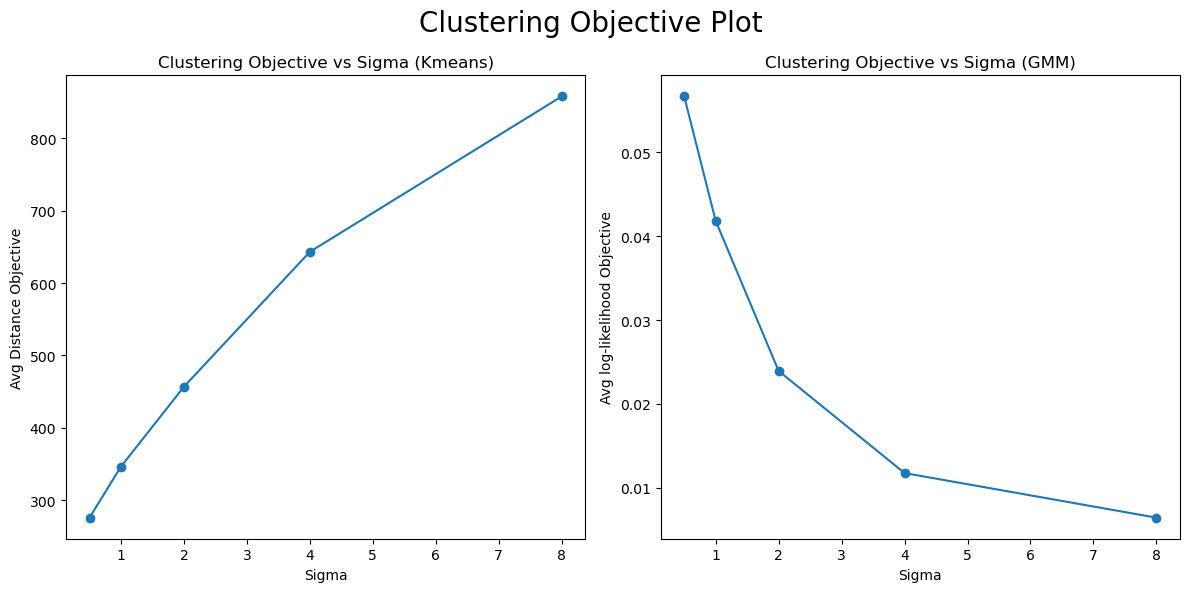

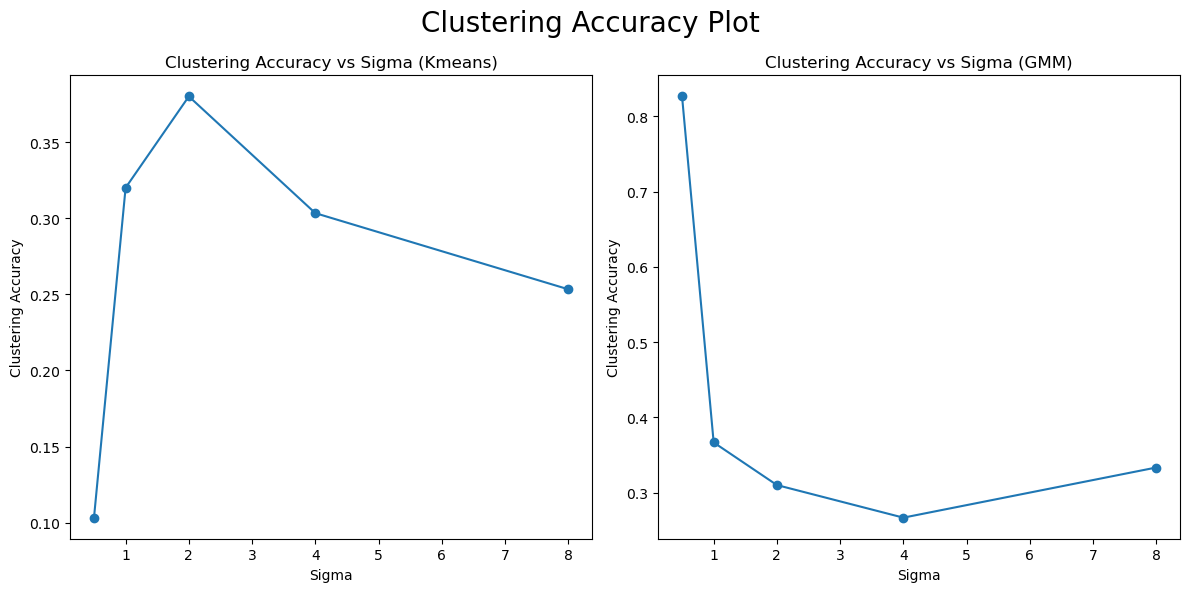

In [351]:
# Clustering Objective Plot KMean
plt.figure(figsize=(12, 6))
plt.suptitle('Clustering Objective Plot ', fontsize=20)
plt.subplot(1, 2, 1)
plt.plot(sigmas, kmeans_objectives, marker='o',)
plt.xlabel('Sigma')
plt.ylabel('Avg Distance Objective')
plt.title('Clustering Objective vs Sigma (Kmeans)')

plt.subplot(1, 2, 2)
plt.plot(sigmas, gmm_objectives, marker='o')
plt.xlabel('Sigma')
plt.ylabel('Avg log-likelihood Objective')
plt.title('Clustering Objective vs Sigma (GMM)')
plt.tight_layout()
plt.show()

#Clustering Accuracy Plot
plt.figure(figsize=(12, 6))
plt.suptitle('Clustering Accuracy Plot ', fontsize=20)
plt.subplot(1, 2, 1)
plt.plot(sigmas, kmeans_accuracies, marker='o')
plt.xlabel('Sigma')
plt.ylabel('Clustering Accuracy')
plt.title('Clustering Accuracy vs Sigma (Kmeans)')

plt.subplot(1, 2, 2)
plt.plot(sigmas, gmm_accuracies, marker='o')
plt.xlabel('Sigma')
plt.ylabel('Clustering Accuracy')
plt.title('Clustering Accuracy vs Sigma (GMM)')

plt.tight_layout()
plt.show()